# Deep Dream

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2016/01/13<br>
**Last modified:** 2020/05/02<br>
**Description:** Generating Deep Dreams with Keras.

## Introduction

"Deep dream" is an image-filtering technique which consists of taking an image
classification model, and running gradient ascent over an input image to
try to maximize the activations of specific layers (and sometimes, specific units in
specific layers) for this input. It produces hallucination-like visuals.

It was first introduced by Alexander Mordvintsev from Google in July 2015.

Process:

- Load the original image.
- Define a number of processing scales ("octaves"),
from smallest to largest.
- Resize the original image to the smallest scale.
- For every scale, starting with the smallest (i.e. current one):
    - Run gradient ascent
    - Upscale image to the next scale
    - Reinject the detail that was lost at upscaling time
- Stop when we are back to the original size.
To obtain the detail lost during upscaling, we simply
take the original image, shrink it down, upscale it,
and compare the result to the (resized) original image.


## What is Deep Dream? 

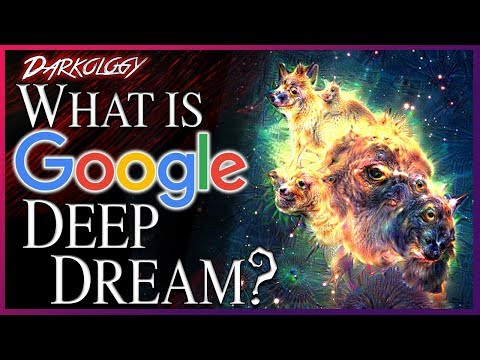

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('f23vEzI3LQ0', width=400, height=300)

## Journey on the Deep Dream

An example work created by a deep dream algorithm.

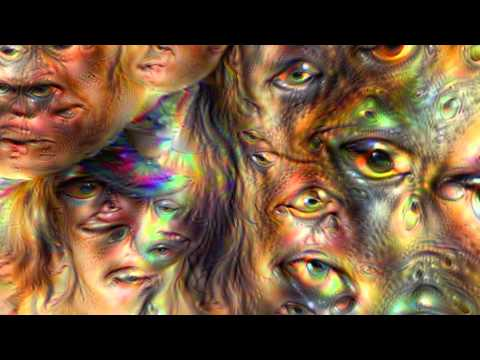

In [2]:
from IPython.display import YouTubeVideo

YouTubeVideo('SCE-QeDfXtA', width=400, height=300)

## Setup


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3

base_image_path = keras.utils.get_file("original.jpg",
                                       "http://www.reidsitaly.com/site/assets/files/3147/pablo-picasso-self-portraits-over-the-years.-toppic.jpg")
result_prefix = "dreamed"

# These are the names of the layers
# for which we try to maximize activation,
# as well as their weight in the final loss
# we try to maximize.
# You can tweak these setting to obtain new visual effects.
layer_settings = {
    "mixed4": 2.0,
    "mixed5": 2.5,
    "mixed6": 3.0,
    "mixed7": 5,
}

# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale
max_loss = 15.0


This is our base image:


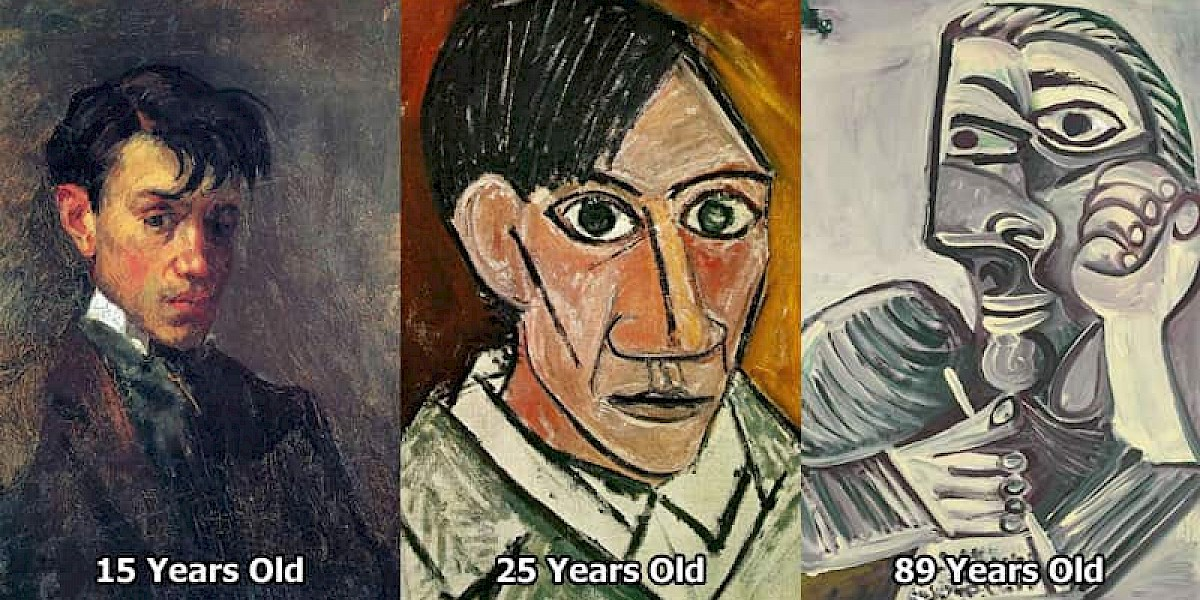

In [4]:
from IPython.display import Image, display

display(Image(base_image_path, width = 600, height = 300))

Let's set up some image preprocessing/deprocessing utilities:


In [5]:

def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate arrays.
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a NumPy array into a valid image.
    x = x.reshape((x.shape[1], x.shape[2], 3))
    # Undo inception v3 preprocessing
    x /= 2.0
    x += 0.5
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x



## Compute the Deep Dream loss

First, build a feature extraction model to retrieve the activations of our target layers
given an input image.


In [6]:
# Build an InceptionV3 model loaded with pre-trained ImageNet weights
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)

# Set up a model that returns the activation values for every target layer
# (as a dict)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)


The actual loss computation is very simple:


In [7]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    # Initialize the loss
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        # We avoid border artifacts by only involving non-border pixels in the loss.
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))
        loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling
    return loss

## Set up the gradient ascent loop for one octave


In [8]:
@tf.function
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    img += learning_rate * grads
    return loss, img


def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, img = gradient_ascent_step(img, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print("... Loss value at step %d: %.2f" % (i, loss))
    return img

## Run the training loop, iterating over different octaves


In [9]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)  # Make a copy
for i, shape in enumerate(successive_shapes):
    print("Processing octave %d with shape %s" % (i, shape))
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.preprocessing.image.save_img(result_prefix + ".png", deprocess_image(img.numpy()))

Processing octave 0 with shape (306, 612)
... Loss value at step 0: 1.17
... Loss value at step 1: 1.58
... Loss value at step 2: 1.98
... Loss value at step 3: 2.37
... Loss value at step 4: 2.55
... Loss value at step 5: 2.83
... Loss value at step 6: 3.21
... Loss value at step 7: 3.33
... Loss value at step 8: 3.62
... Loss value at step 9: 3.93
... Loss value at step 10: 4.20
... Loss value at step 11: 4.45
... Loss value at step 12: 4.88
... Loss value at step 13: 4.86
... Loss value at step 14: 5.25
... Loss value at step 15: 5.35
... Loss value at step 16: 5.62
... Loss value at step 17: 6.09
... Loss value at step 18: 6.43
... Loss value at step 19: 6.79
Processing octave 1 with shape (428, 857)
... Loss value at step 0: 1.52
... Loss value at step 1: 2.20
... Loss value at step 2: 2.67
... Loss value at step 3: 3.05
... Loss value at step 4: 3.44
... Loss value at step 5: 3.66
... Loss value at step 6: 4.14
... Loss value at step 7: 4.36
... Loss value at step 8: 4.81
... Los

Display the result.


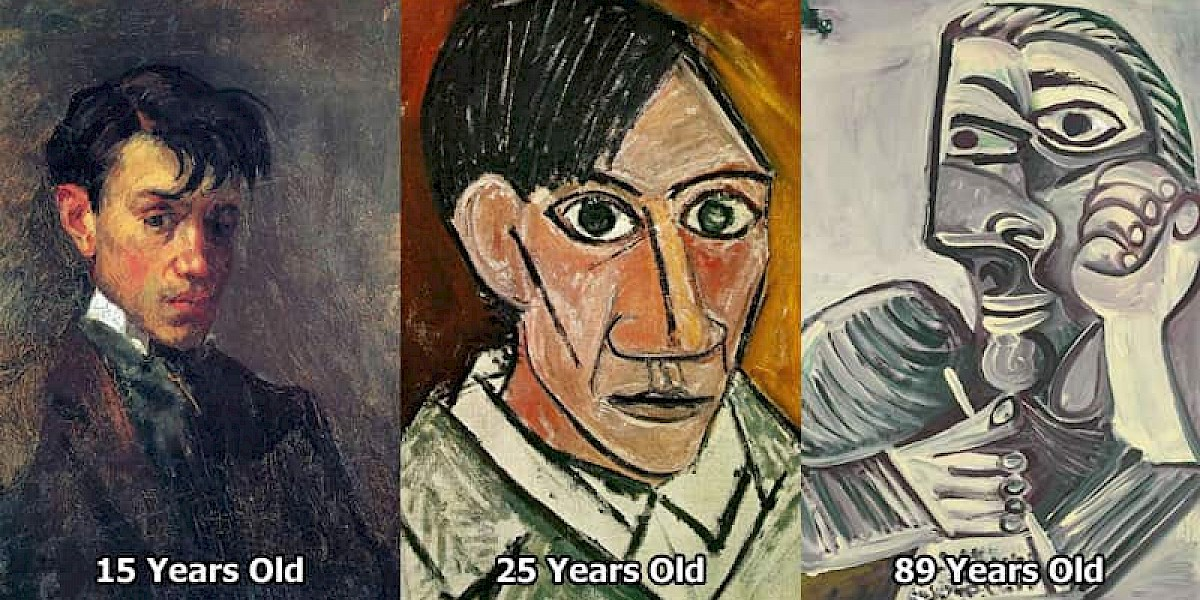

In [11]:
# Original image
display(Image(base_image_path, width = 600, height = 300))

In [12]:
# Transformed
display(Image(result_prefix + ".png", width = 600, height = 300))

Output hidden; open in https://colab.research.google.com to view.